# Section 1 | Libraries Needed

In [ ]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import colors
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Section 2 | Reading the data

Taking only one row from each 14 to reduce the runtime.

In [ ]:
data = pd.read_csv("weatherAUS.csv")
data = data[data.index % 14 == 0]
data.to_csv('result.csv', index=False)
data = pd.read_csv("result.csv")
data.tail()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
10385,2017-04-17,Uluru,19.3,24.4,0.0,NaN,NaN,W,35.0,ESE,...,28.0,91.0,1015.9,1013.9,8.0,8.0,21.3,18.5,No,Yes
10386,2017-05-01,Uluru,6.4,25.4,0.0,NaN,NaN,SSW,28.0,SE,...,55.0,25.0,1019.6,1017.4,NaN,NaN,15.2,23.9,No,No
10387,2017-05-15,Uluru,5.3,28.2,0.0,NaN,NaN,WNW,39.0,SE,...,41.0,19.0,1017.5,1012.9,NaN,NaN,14.0,27.6,No,No
10388,2017-05-29,Uluru,12.7,22.2,0.0,NaN,NaN,E,37.0,E,...,59.0,34.0,1024.3,1021.7,8.0,8.0,13.9,21.0,No,No
10389,2017-06-12,Uluru,5.1,19.7,0.0,NaN,NaN,E,46.0,ESE,...,56.0,29.0,1028.5,1025.8,NaN,NaN,8.5,19.2,No,No


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10390 entries, 0 to 10389
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           10390 non-null  object 
 1   Location       10390 non-null  object 
 2   MinTemp        10278 non-null  float64
 3   MaxTemp        10300 non-null  float64
 4   Rainfall       10107 non-null  float64
 5   Evaporation    5907 non-null   float64
 6   Sunshine       5402 non-null   float64
 7   WindGustDir    9647 non-null   object 
 8   WindGustSpeed  9653 non-null   float64
 9   WindDir9am     9659 non-null   object 
 10  WindDir3pm     10085 non-null  object 
 11  WindSpeed9am   10262 non-null  float64
 12  WindSpeed3pm   10172 non-null  float64
 13  Humidity9am    10197 non-null  float64
 14  Humidity3pm    10066 non-null  float64
 15  Pressure9am    9321 non-null   float64
 16  Pressure3pm    9320 non-null   float64
 17  Cloud9am       6365 non-null   float64
 18  Cloud3

We can see that the total number of rows is 10390, some features have missing values so we need to fill them.

And we can also see that we have numeric and categorical data.

This figure shows the correlation between the numeric data.

# Section 3 | Data Visualizations and Data Preprocessing

## Section 3.1 | Numeric Data Correlation.

<ipython-input-4-7485798304e1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True,cmap='Blues',mask=np.triu(data.corr(),+1));


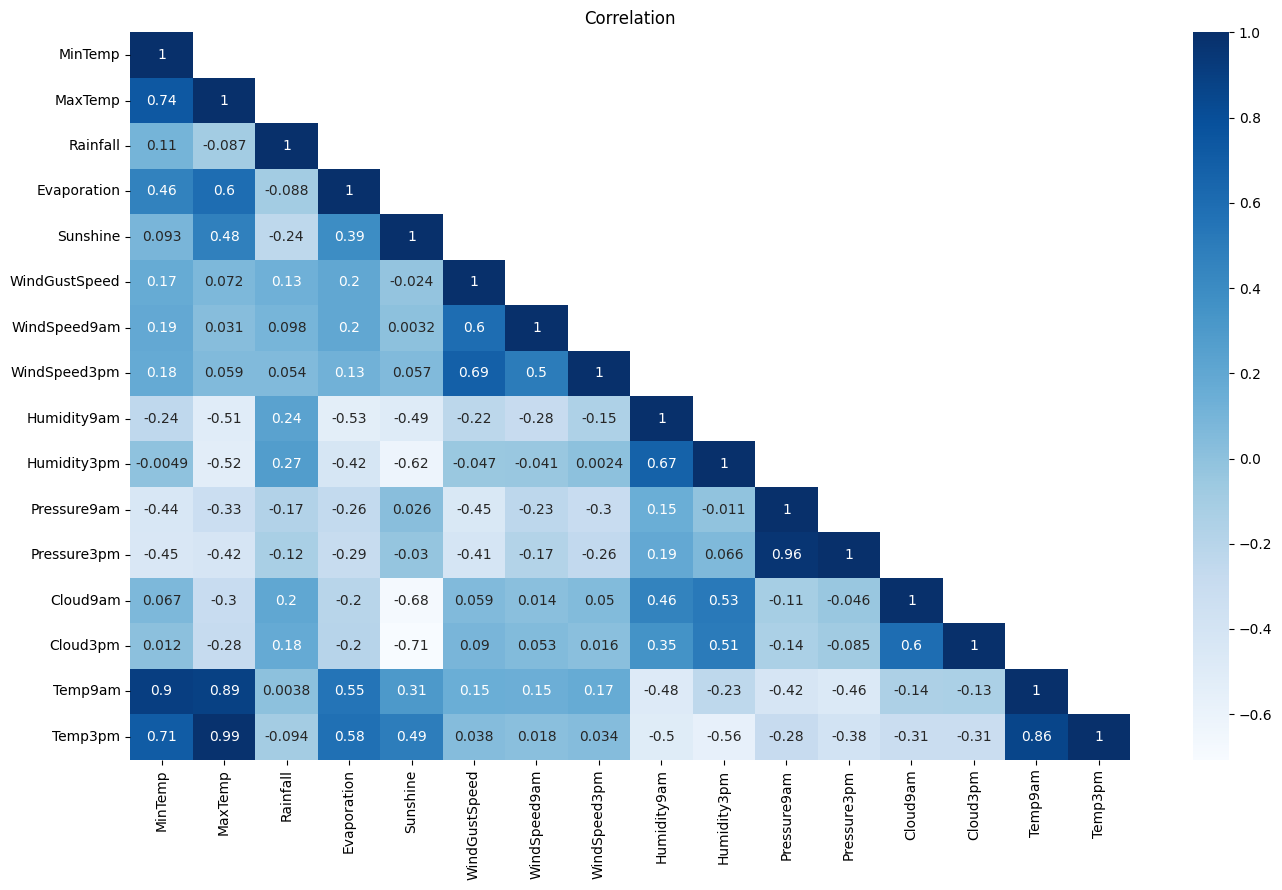

In [ ]:
plt.figure(figsize=(14,9))
sns.heatmap(data.corr(),annot=True,cmap='Blues',mask=np.triu(data.corr(),+1));
plt.title('Correlation');
plt.tight_layout()

## Section 3.2 | Removing the date

The date is considered as noise, so we need to remove it, but the month is important because it is related to the raining periods so we will keep it.

In [ ]:
data['Date']= pd.to_datetime(data["Date"])
data['month'] = data.Date.dt.month
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10390 entries, 0 to 10389
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           10390 non-null  datetime64[ns]
 1   Location       10390 non-null  object        
 2   MinTemp        10278 non-null  float64       
 3   MaxTemp        10300 non-null  float64       
 4   Rainfall       10107 non-null  float64       
 5   Evaporation    5907 non-null   float64       
 6   Sunshine       5402 non-null   float64       
 7   WindGustDir    9647 non-null   object        
 8   WindGustSpeed  9653 non-null   float64       
 9   WindDir9am     9659 non-null   object        
 10  WindDir3pm     10085 non-null  object        
 11  WindSpeed9am   10262 non-null  float64       
 12  WindSpeed3pm   10172 non-null  float64       
 13  Humidity9am    10197 non-null  float64       
 14  Humidity3pm    10066 non-null  float64       
 15  Pressure9am    9321

## Section 3.3 | Filling Categorical and Numeric data

Here we will fill the missing data for categorical features with the mode. Categorical data represents distinct categories without any inherent order or numerical meaning. Filling missing values with the mode maintains this integrity.

In [ ]:
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols, "\n")

for i in object_cols:
    print(i, data[i].isnull().sum())

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

print()

for i in object_cols:
    print(i, data[i].isnull().sum())

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'] 

Location 0
WindGustDir 743
WindDir9am 731
WindDir3pm 305
RainToday 283
RainTomorrow 192

Location 0
WindGustDir 0
WindDir9am 0
WindDir3pm 0
RainToday 0
RainTomorrow 0


And here, we will fil the numeric missing data with the median of the feature, because we don't want to introduce new values to the dataset, we will try to keep it as it is.

In [ ]:
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Neumeric variables:")
print(num_cols, '\n')

for i in num_cols:
    print(i, data[i].isnull().sum())

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

print()

for i in num_cols:
    print(i, data[i].isnull().sum())

print()

data.info()

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'] 

MinTemp 112
MaxTemp 90
Rainfall 283
Evaporation 4483
Sunshine 4988
WindGustSpeed 737
WindSpeed9am 128
WindSpeed3pm 218
Humidity9am 193
Humidity3pm 324
Pressure9am 1069
Pressure3pm 1070
Cloud9am 4025
Cloud3pm 4249
Temp9am 124
Temp3pm 256

MinTemp 0
MaxTemp 0
Rainfall 0
Evaporation 0
Sunshine 0
WindGustSpeed 0
WindSpeed9am 0
WindSpeed3pm 0
Humidity9am 0
Humidity3pm 0
Pressure9am 0
Pressure3pm 0
Cloud9am 0
Cloud3pm 0
Temp9am 0
Temp3pm 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10390 entries, 0 to 10389
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           10390 non-null  datetime64[ns]
 1   Location       10390 non-null  object        
 2   MinT

We can see here that all of the fields are now non-null.

## Section 3.4 | Data Visualization

We will split the data into categorical and numeric.

In [ ]:
data_draw = data.drop(['Date'], axis=1)
df_categorical = data_draw[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].astype(str)
df_numerical = data_draw.drop(df_categorical.columns, axis=1)
df_numerical = df_numerical.drop(["Location"], axis=1)

If we want to draw the location as a pie chart, the visualization will not be clear because it contains a lot of distinct values, so we will represent it using a table, with the count of each value.

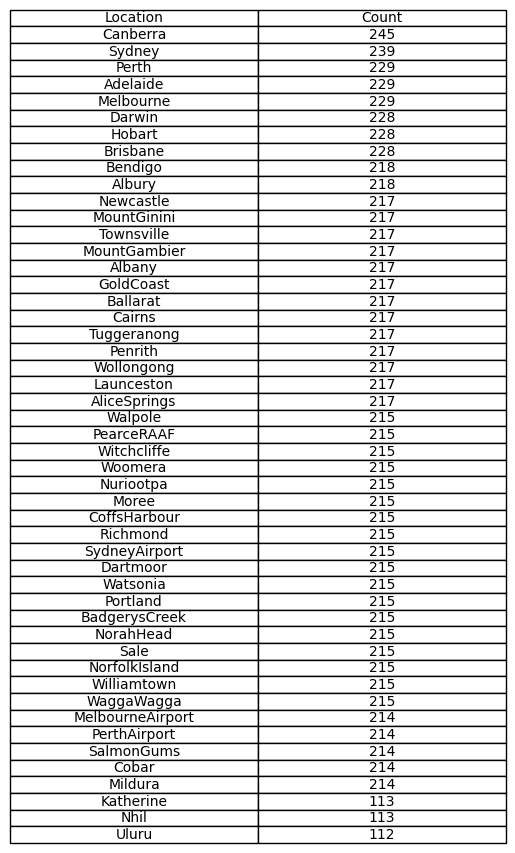

In [ ]:
location_counts = data['Location'].value_counts()

location_counts_df = pd.DataFrame({'Location': location_counts.index, 'Count': location_counts.values})

fig, ax = plt.subplots()
ax.axis('off')

table = ax.table(cellText=location_counts_df.values, colLabels=location_counts_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.show()

In [ ]:
fig = make_subplots(rows=3, cols=3, specs=[[{'type':'domain'}]*3]*3, vertical_spacing=0.05, horizontal_spacing=0.01)

for i, feature in enumerate(df_categorical.columns):
    value_counts = df_categorical[feature].value_counts()
    labels = value_counts.index.tolist()
    values = value_counts.values.tolist()

    cmap = colors.LinearSegmentedColormap.from_list("blue", ["darkblue", "white"])
    norm = colors.Normalize(vmin=0, vmax=len(labels))
    color_list = [colors.rgb2hex(cmap(norm(i))) for i in range(len(labels))]

    pie_chart = go.Pie(
        labels=labels,
        values=values,
        hole=0.6,
        marker=dict(colors=color_list, line=dict(color='white', width=3)),
        textposition='inside',
        textinfo='percent+label',
        title=feature,
        title_font=dict(size=25, color='black', family='Calibri')
    )

    if i < 8:
        row = i // 3 + 1
        col = i % 3 + 1
        fig.add_trace(pie_chart, row=row, col=col)

fig.update_layout(showlegend=False, height=1000, width=980,
                   title={
                          'text':"Distribution of Categorical Variables",
                          'y':0.95,
                          'x':0.5,
                          'xanchor':'center',
                          'yanchor':'top',
                          'font': {'size':28, 'color':'black', 'family':'Calibri'}
                         })

fig.show()

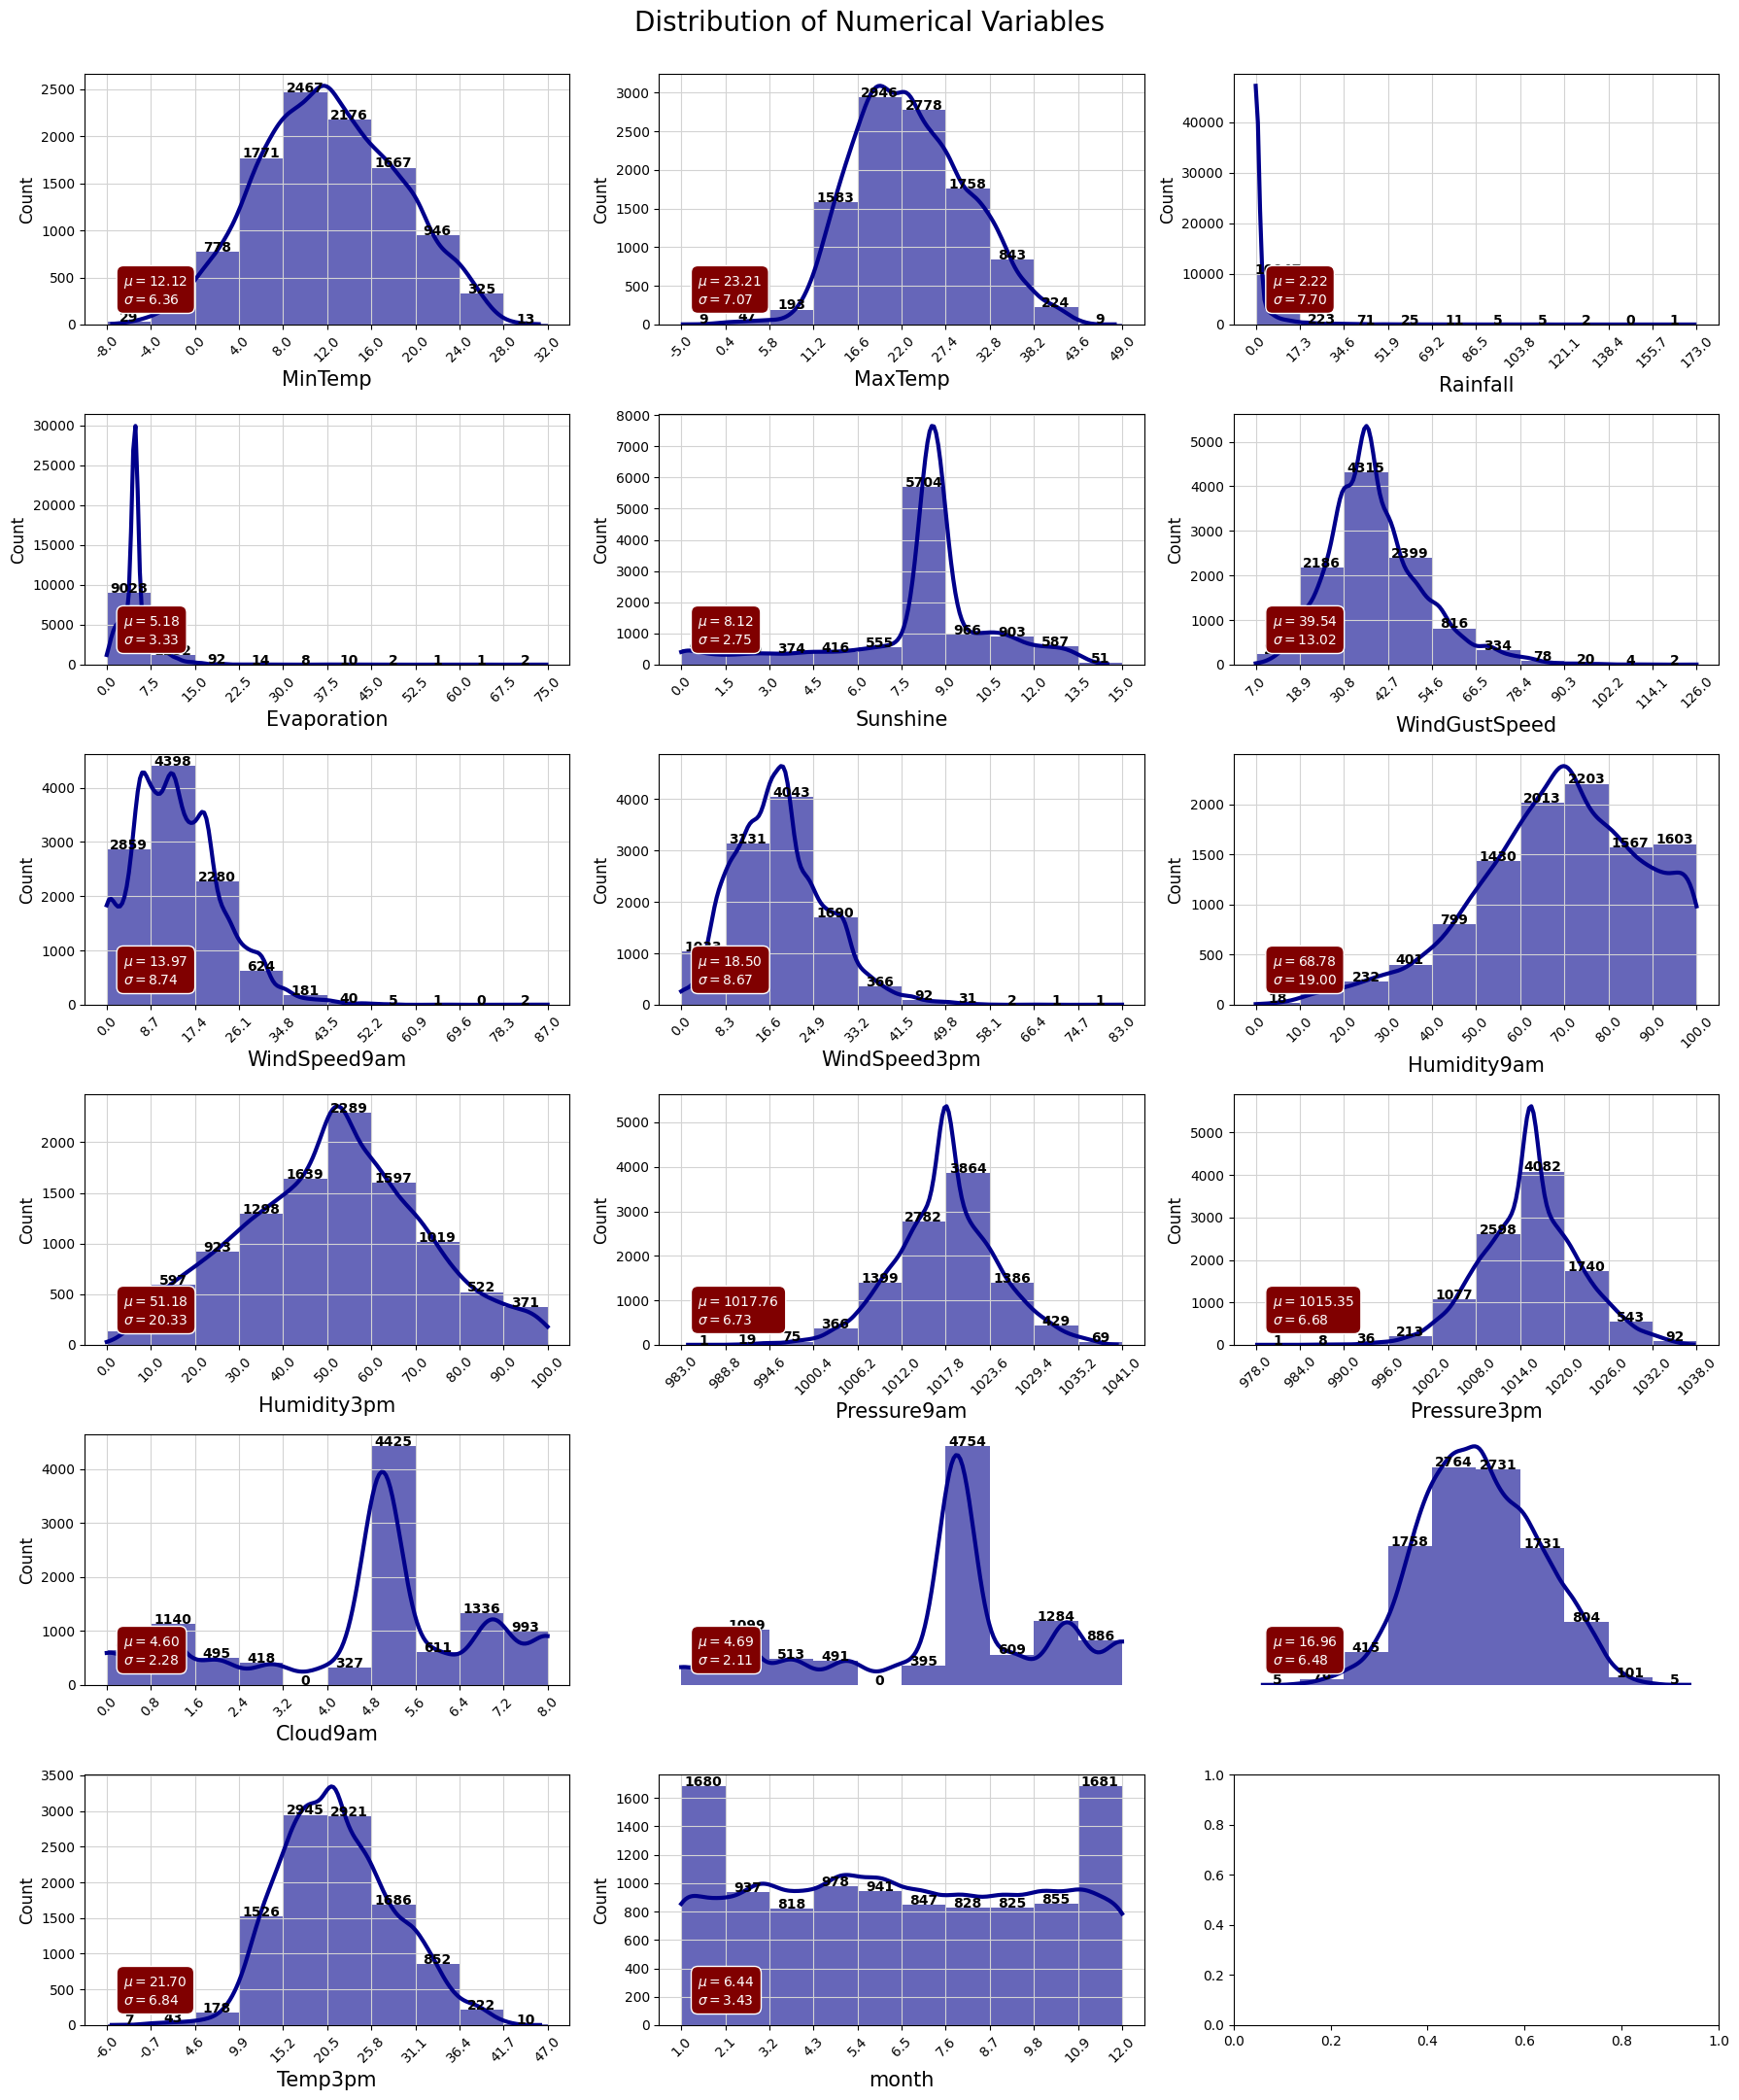

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(18,22))
c = 'darkblue'


for i, col in enumerate(df_numerical.columns):
    x = i//3
    y = i%3
    values, bin_edges = np.histogram(df_numerical[col],
                                     range=(np.floor(df_numerical[col].min()), np.ceil(df_numerical[col].max())))
    graph = sns.histplot(data=df_numerical, x=col, bins=bin_edges, kde=True, ax=ax[x,y],
                         edgecolor='none', color=c, alpha=0.6, line_kws={'lw': 3})
    ax[x,y].set_xlabel(col, fontsize=15)
    ax[x,y].set_ylabel('Count', fontsize=12)
    ax[x,y].set_xticks(np.round(bin_edges,1))
    ax[x,y].set_xticklabels(ax[x,y].get_xticks(), rotation = 45)
    ax[x,y].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[x,y].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")
    textstr = '\n'.join((
    r'$\mu=%.2f$' %df_numerical[col].mean(),
    r'$\sigma=%.2f$' %df_numerical[col].std()
    ))
    ax[x,y].text(0.08, 0.2, textstr, transform=ax[x,y].transAxes, fontsize=10, verticalalignment='top',
                color='white', bbox=dict(boxstyle='round',facecolor='maroon', edgecolor='white', pad=0.5))

ax[4, 1].axis('off')
ax[4, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## Section 3.5 | Encoding categorical data

Encnoding the categorical values into numeric values, to process them in the models.

In [ ]:
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10390 entries, 0 to 10389
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           10390 non-null  datetime64[ns]
 1   Location       10390 non-null  int64         
 2   MinTemp        10390 non-null  float64       
 3   MaxTemp        10390 non-null  float64       
 4   Rainfall       10390 non-null  float64       
 5   Evaporation    10390 non-null  float64       
 6   Sunshine       10390 non-null  float64       
 7   WindGustDir    10390 non-null  int64         
 8   WindGustSpeed  10390 non-null  float64       
 9   WindDir9am     10390 non-null  int64         
 10  WindDir3pm     10390 non-null  int64         
 11  WindSpeed9am   10390 non-null  float64       
 12  WindSpeed3pm   10390 non-null  float64       
 13  Humidity9am    10390 non-null  float64       
 14  Humidity3pm    10390 non-null  float64       
 15  Pressure9am    1039

## Section 3.6 | Scaling the data

The table below shows the data before scaling them, we can see that we have large and small values, which is not good for the training, we will try to wrap the values around the mean so all values become close and small.

In [ ]:
features = data.drop(['RainTomorrow', 'Date'], axis=1)
col_names = list(features.columns)
features = pd.DataFrame(features, columns=col_names)
features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,10390.0,23.790857,14.231508,0.0,11.0,24.00,36.000,48.0
MinTemp,10390.0,12.123330,6.363571,-7.5,7.6,11.90,16.700,31.2
MaxTemp,10390.0,23.213888,7.068553,-4.8,18.1,22.60,28.075,48.1
Rainfall,10390.0,2.224909,7.704194,0.0,0.0,0.00,0.600,172.2
Evaporation,10390.0,5.178229,3.325404,0.0,4.0,4.80,5.400,74.8
Sunshine,10390.0,8.116805,2.749830,0.0,8.3,8.55,8.800,14.5
WindGustDir,10390.0,7.797690,4.483472,0.0,4.0,9.00,11.000,15.0
WindGustSpeed,10390.0,39.535130,13.022178,7.0,31.0,37.00,46.000,126.0
WindDir9am,10390.0,6.928970,4.493196,0.0,3.0,7.00,11.000,15.0
WindDir3pm,10390.0,7.779596,4.536727,0.0,4.0,8.00,12.000,15.0


In [ ]:
target = data['RainTomorrow']
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)
features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,10390.0,1.094195e-16,1.000048,-1.671784,-0.898814,0.014697,0.857937,1.701177
MinTemp,10390.0,-3.009036e-17,1.000048,-3.083846,-0.710851,-0.035097,0.719233,2.997938
MaxTemp,10390.0,2.188390e-17,1.000048,-3.963362,-0.723505,-0.086852,0.687743,3.520849
Rainfall,10390.0,2.735487e-18,1.000048,-0.288806,-0.288806,-0.288806,-0.210922,22.063731
Evaporation,10390.0,1.477163e-16,1.000048,-1.557248,-0.354329,-0.113745,0.066693,20.937343
Sunshine,10390.0,5.525684e-16,1.000048,-2.951890,0.066624,0.157543,0.248462,2.321418
WindGustDir,10390.0,-1.367743e-17,1.000048,-1.739291,-0.847083,0.268178,0.714282,1.606491
WindGustSpeed,10390.0,-2.188390e-17,1.000048,-2.498560,-0.655462,-0.194687,0.496475,6.640136
WindDir9am,10390.0,8.753558e-17,1.000048,-1.542177,-0.874469,0.015809,0.906087,1.796364
WindDir3pm,10390.0,7.932912e-17,1.000048,-1.714886,-0.833151,0.048585,0.930320,1.591621


As we can see in the table above, the values are now near the mean since the standard deviation is almost 1 for all of the features, and the data is scaled.

## Section 3.7 | Removing the outliers

<ipython-input-15-ae8f7485a8c5>:3: UserWarning:


The palette list has fewer values (5) than needed (22) and will cycle, which may produce an uninterpretable plot.



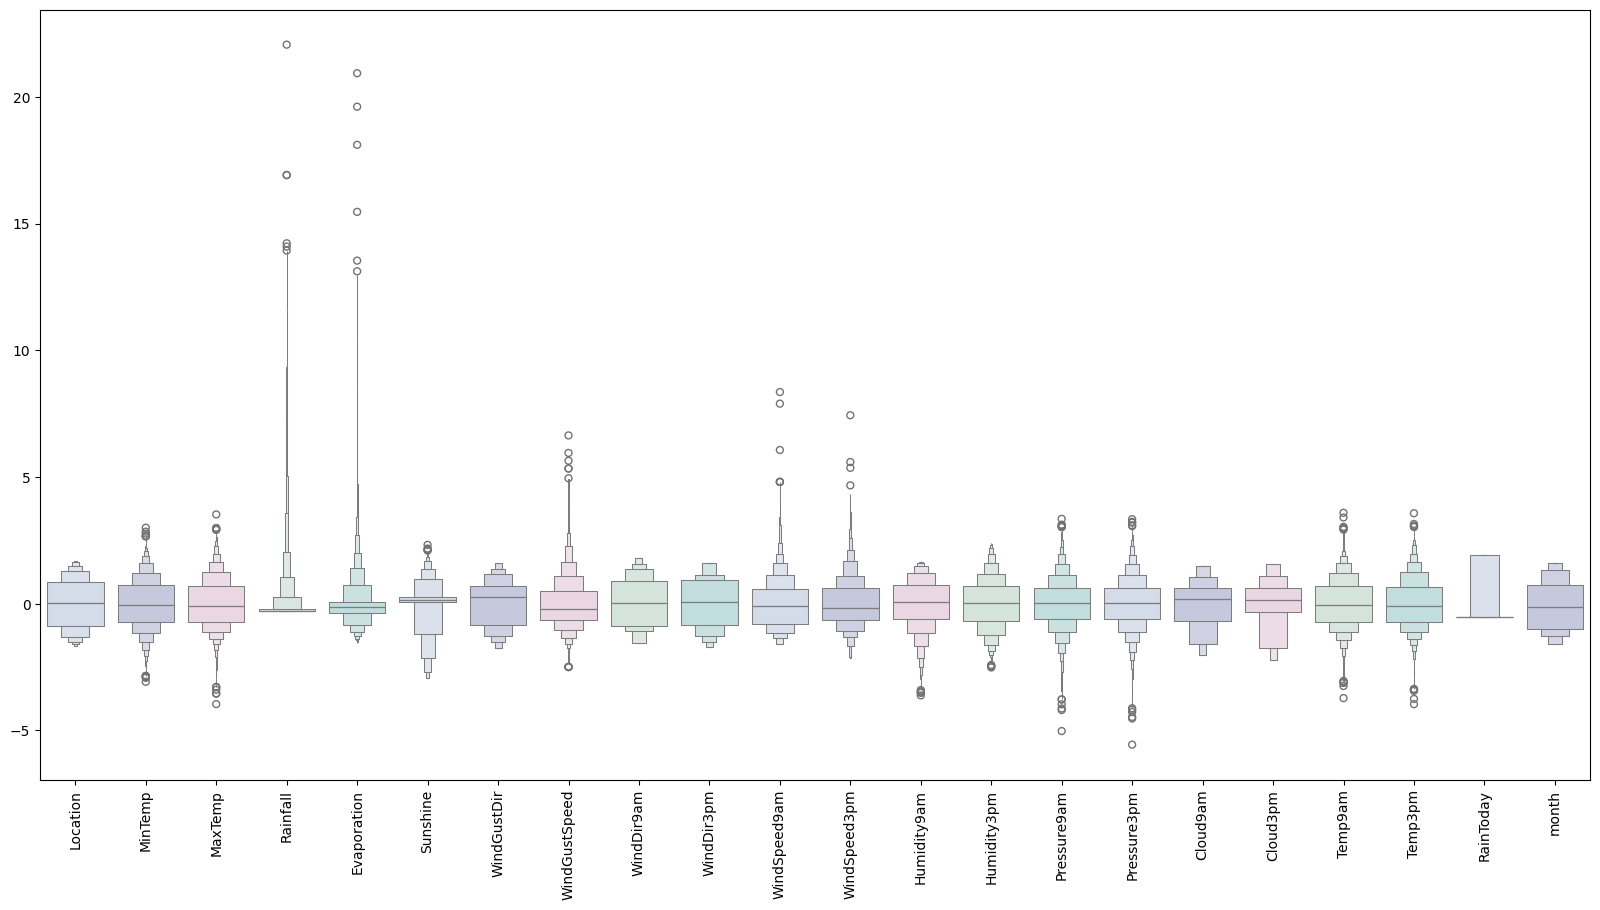

In [ ]:
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20, 10))
sns.boxenplot(data=features, palette=colours)
plt.xticks(rotation=90)
plt.show()

The figure above shows the box plot for each feature, we can see a lot of outliers in the scaled data, so we will try to get rid of them manually.

In [ ]:
features["RainTomorrow"] = target

features = features[(features["MinTemp"]<1.8)&(features["MinTemp"]>-1.7)]
features = features[(features["MaxTemp"]<1.7)&(features["MaxTemp"]>-1.7)]
features = features[(features["Rainfall"]<1.5)]
features = features[(features["Evaporation"]<1.8)]
features = features[(features["Sunshine"]<1.7)]
features = features[(features["WindGustSpeed"]<2.5)&(features["WindGustSpeed"]>-2)]
features = features[(features["WindSpeed9am"]<3)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-2.2)]
features = features[(features["Humidity3pm"]>-1.8)]
features = features[(features["Pressure9am"]< 1.7)&(features["Pressure9am"]>-1.7)]
features = features[(features["Pressure3pm"]< 1.7)&(features["Pressure3pm"]>-1.5)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-1.6)]

features.shape

(6774, 23)

<ipython-input-17-d3a7b3e4bca7>:2: UserWarning:


The palette list has fewer values (5) than needed (23) and will cycle, which may produce an uninterpretable plot.



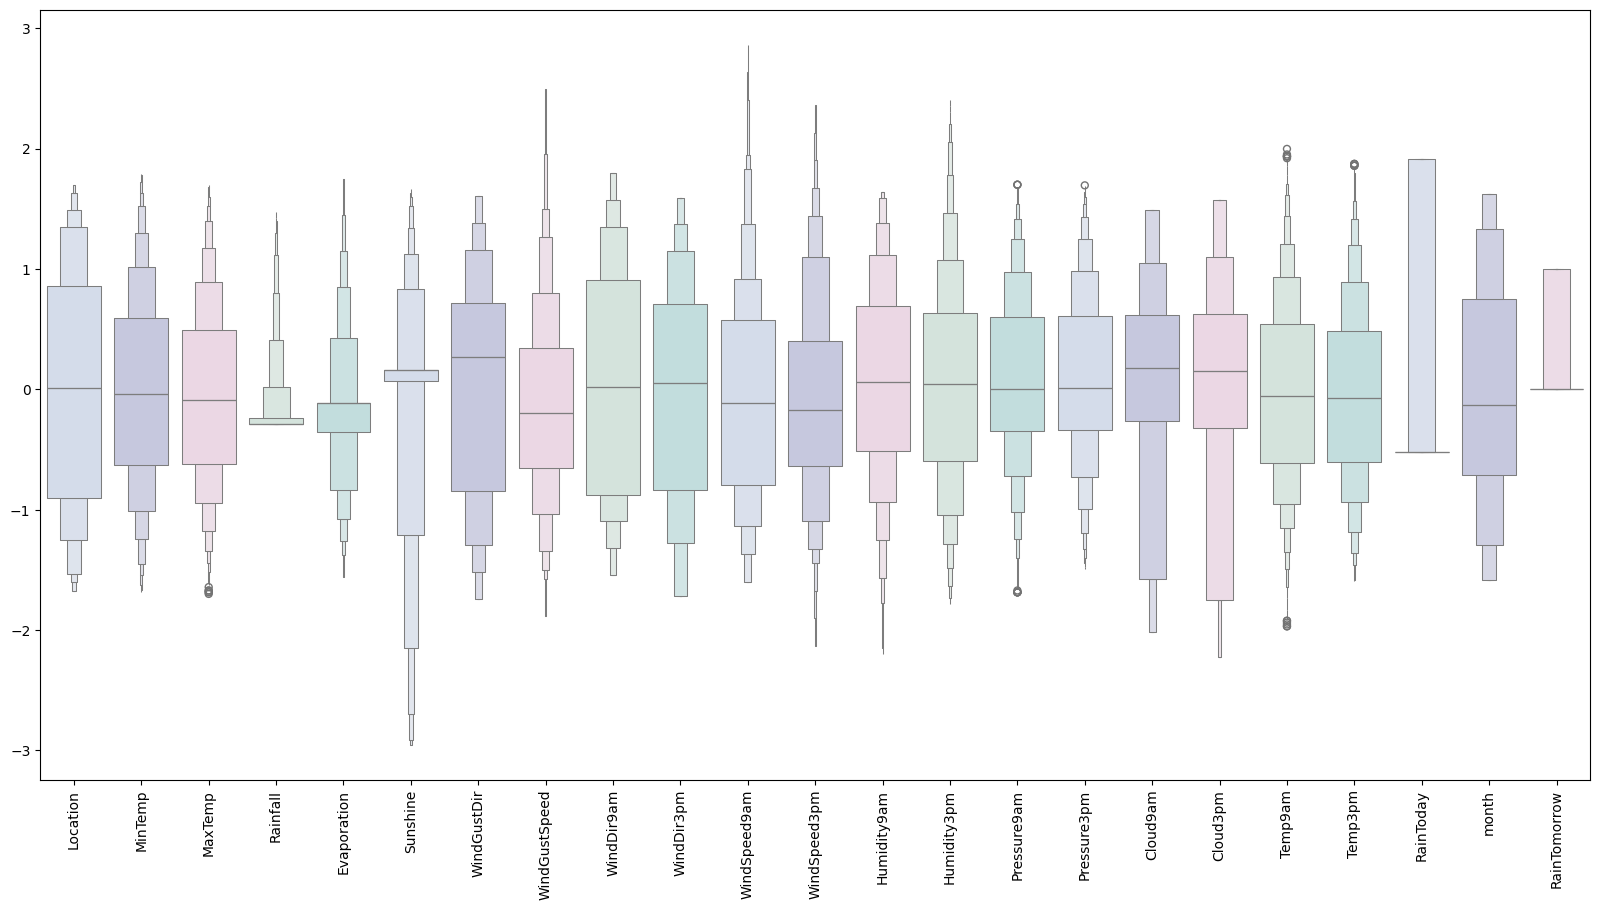

In [ ]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

After studying the figure that contains the outliers, we removed them and got the above figure. Some outliers remain in the box plot, but removing them will introduce new outliers to the filtered data, so we will keep them as they appear above.

## Section 3.8 | Preparing the data for the models

Now we will split the data into training (training + validation) and testing sets.

In [ ]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Section 4 | KNN Model

Fitting for K = 1
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters for KNN with n_neighbors=1: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Best Cross-validated Accuracy: 0.7956107472667208


Fitting for K = 3
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters for KNN with n_neighbors=3: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best Cross-validated Accuracy: 0.8196562670899414

Training Accuracy for KNN with n_neighbors=1: 1.0

Training Accuracy for KNN with n_neighbors=3: 0.895169795401814


Classification Report for KNN with n_neighbors=1:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1622
           1       0.43      0.36      0.39       411

    accuracy                           0.77      2033
   macro avg       0.64      0.62      0.63      2033
weight

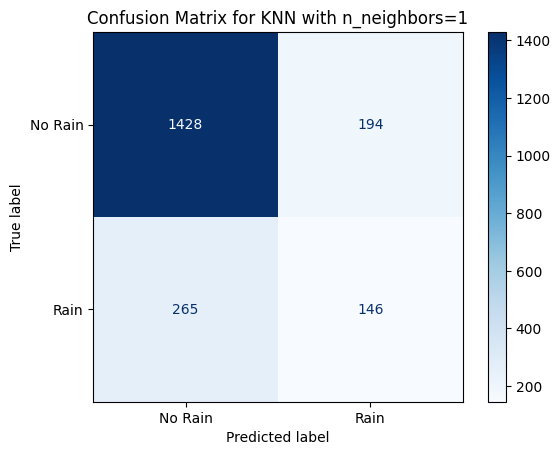



Classification Report for KNN with n_neighbors=3:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1622
           1       0.51      0.29      0.37       411

    accuracy                           0.80      2033
   macro avg       0.67      0.61      0.62      2033
weighted avg       0.77      0.80      0.78      2033



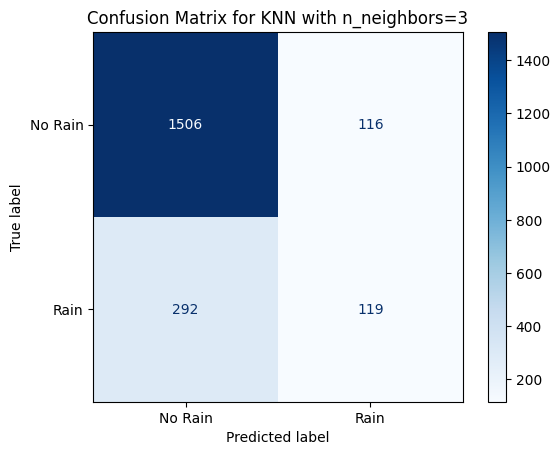

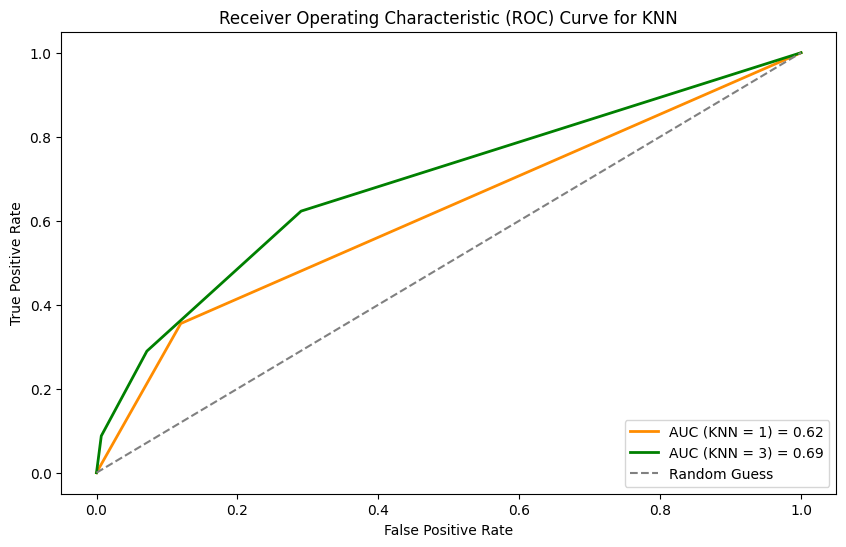

In [ ]:
param_grid_knn_1 = {
    'n_neighbors': [1],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

param_grid_knn_3 = {
    'n_neighbors': [3],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_1 = KNeighborsClassifier()
knn_3 = KNeighborsClassifier()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

print("Fitting for K = 1")
grid_search_knn_1 = GridSearchCV(knn_1, param_grid_knn_1, cv=cv, scoring='accuracy', verbose=1)
grid_search_knn_1.fit(X_train, y_train)

print("Best Parameters for KNN with n_neighbors=1:", grid_search_knn_1.best_params_)
print("Best Cross-validated Accuracy:", grid_search_knn_1.best_score_)

print("\n\nFitting for K = 3")
grid_search_knn_3 = GridSearchCV(knn_3, param_grid_knn_3, cv=cv, scoring='accuracy', verbose=1)
grid_search_knn_3.fit(X_train, y_train)

print("Best Parameters for KNN with n_neighbors=3:", grid_search_knn_3.best_params_)
print("Best Cross-validated Accuracy:", grid_search_knn_3.best_score_)

best_knn_1 = grid_search_knn_1.best_estimator_
train_predictions_knn_1 = best_knn_1.predict(X_train)

train_accuracy_knn_1 = accuracy_score(y_train, train_predictions_knn_1)
print("\nTraining Accuracy for KNN with n_neighbors=1:", train_accuracy_knn_1)

best_knn_3 = grid_search_knn_3.best_estimator_
train_predictions_knn_3 = best_knn_3.predict(X_train)

train_accuracy_knn_3 = accuracy_score(y_train, train_predictions_knn_3)
print("\nTraining Accuracy for KNN with n_neighbors=3:", train_accuracy_knn_3)

test_predictions_knn_1 = best_knn_1.predict(X_test)
test_predictions_knn_3 = best_knn_3.predict(X_test)

print("\n\nClassification Report for KNN with n_neighbors=1:")
print(classification_report(y_test, test_predictions_knn_1))

conf_matrix_knn_1 = confusion_matrix(y_test, test_predictions_knn_1)
disp_knn_1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn_1, display_labels=['No Rain', 'Rain'])
disp_knn_1.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for KNN with n_neighbors=1')
plt.show()

print("\n\nClassification Report for KNN with n_neighbors=3:")
print(classification_report(y_test, test_predictions_knn_3))

conf_matrix_knn_3 = confusion_matrix(y_test, test_predictions_knn_3)
disp_knn_3 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn_3, display_labels=['No Rain', 'Rain'])
disp_knn_3.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for KNN with n_neighbors=3')
plt.show()
print("\n\n")

y_prob_knn_1 = best_knn_1.predict_proba(X_test)[:, 1]
fpr_knn_1, tpr_knn_1, _ = roc_curve(y_test, y_prob_knn_1)
roc_auc_knn_1 = auc(fpr_knn_1, tpr_knn_1)

y_prob_knn_3 = best_knn_3.predict_proba(X_test)[:, 1]
fpr_knn_3, tpr_knn_3, _ = roc_curve(y_test, y_prob_knn_3)
roc_auc_knn_3 = auc(fpr_knn_3, tpr_knn_3)

plt.figure(figsize=(10, 6))
plt.plot(fpr_knn_1, tpr_knn_1, color='darkorange', lw=2, label=f'AUC (KNN = 1) = {roc_auc_knn_1:.2f}')
plt.plot(fpr_knn_3, tpr_knn_3, color='green', lw=2, label=f'AUC (KNN = 3) = {roc_auc_knn_3:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN')
plt.legend(loc='lower right')
plt.show()

The best parameters when applying K = 1 are ({'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'})

The best parameters when applying K = 3 are ({'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'})

We can see that K = 3 predicted more true results (1625) than K = 1 (1574). Also, the ROC curve AUC is higher when K = 3 (0.69, 0.62).

And the best cross-validation accuracy for K = 3 (0.82) is higher than K = 1 (0.80).

The training accuracy for k=1 is equal to 1 and the testing accuracy is 0.80, which implicates overfitting. while in k=3, the training accuracy is 0.89 and the testing accuracy is 0.82, which indicates less overfitting. At k=1, the KNN tends to closely follow the training data and thus shows a high training score. However, in comparison, the test score is quite low, thus indicating overfitting. So, as we increase k, we will notice less overfitting.

# Section 5 | MLP Model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for MLP: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'max_iter': 1000, 'random_state': 0, 'solver': 'adam'}
Best Cross-validated Accuracy: 0.8377946139173813

Training Accuracy for MLP: 0.9352457287492091


Classification Report for MLP:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1622
           1       0.56      0.36      0.44       411

    accuracy                           0.81      2033
   macro avg       0.71      0.64      0.66      2033
weighted avg       0.79      0.81      0.80      2033



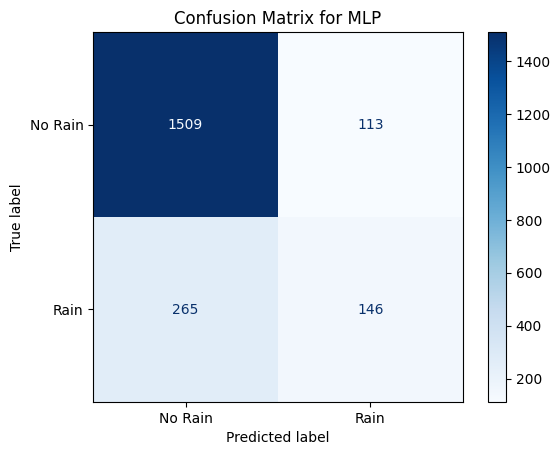

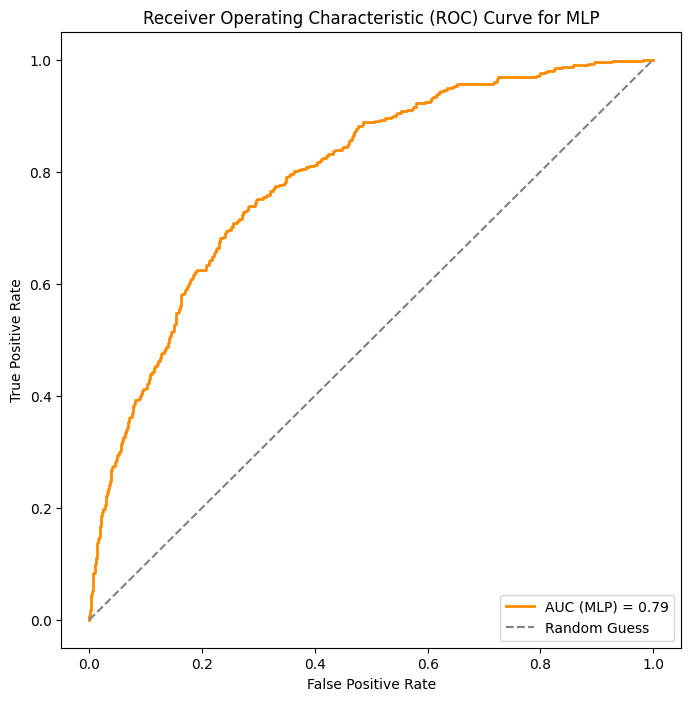

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam'],
    'max_iter': [1000],
    'random_state': [0],
}

mlp = MLPClassifier()

grid_search_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='accuracy', verbose=1)
grid_search_mlp.fit(X_train, y_train)

print("Best Parameters for MLP:", grid_search_mlp.best_params_)
print("Best Cross-validated Accuracy:", grid_search_mlp.best_score_)

best_mlp = grid_search_mlp.best_estimator_
best_mlp.fit(X_train, y_train)

train_predictions_mlp = best_mlp.predict(X_train)

train_accuracy_mlp = accuracy_score(y_train, train_predictions_mlp)
print("\nTraining Accuracy for MLP:", train_accuracy_mlp)

test_predictions_mlp = best_mlp.predict(X_test)

print("\n\nClassification Report for MLP:")
print(classification_report(y_test, test_predictions_mlp))

conf_matrix_mlp = confusion_matrix(y_test, test_predictions_mlp)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_mlp, display_labels=['No Rain', 'Rain'])
disp_mlp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for MLP')
plt.show()

y_prob_mlp = best_mlp.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
print("\n\n")

plt.figure(figsize=(8, 8))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'AUC (MLP) = {roc_auc_mlp:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for MLP')
plt.legend(loc='lower right')
plt.show()

The MLP model shows improvement on the KNN model.

The best parameters for the MLP model are ({'activation': 'logistic', 'hidden_layer_sizes': (100,), 'max_iter': 1000, 'random_state': 0, 'solver': 'adam'})

The best cross-validation accuracy for the MLP model = 0.84 but the training accuracy is 0.94, whic indicates that the model might be overfitted.

The AUC for the ROC curve = 0.79.

And the number of true predicted values = 1655.

# Section 6 | SVC Model

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'C': 1}
Best Cross-validated Accuracy: 0.8502418713013477

Training Accuracy: 0.8747099767981439

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1622
           1       0.78      0.30      0.43       411

    accuracy                           0.84      2033
   macro avg       0.81      0.64      0.67      2033
weighted avg       0.83      0.84      0.81      2033



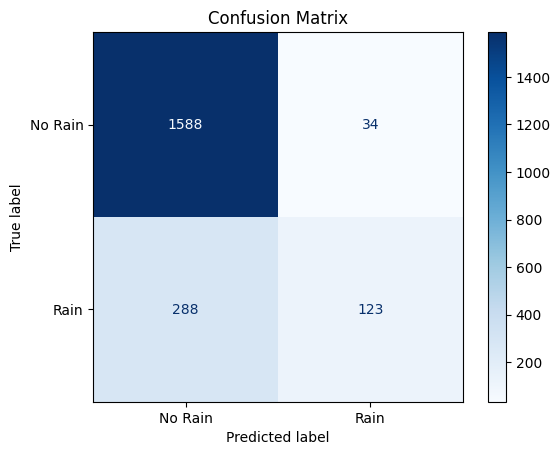

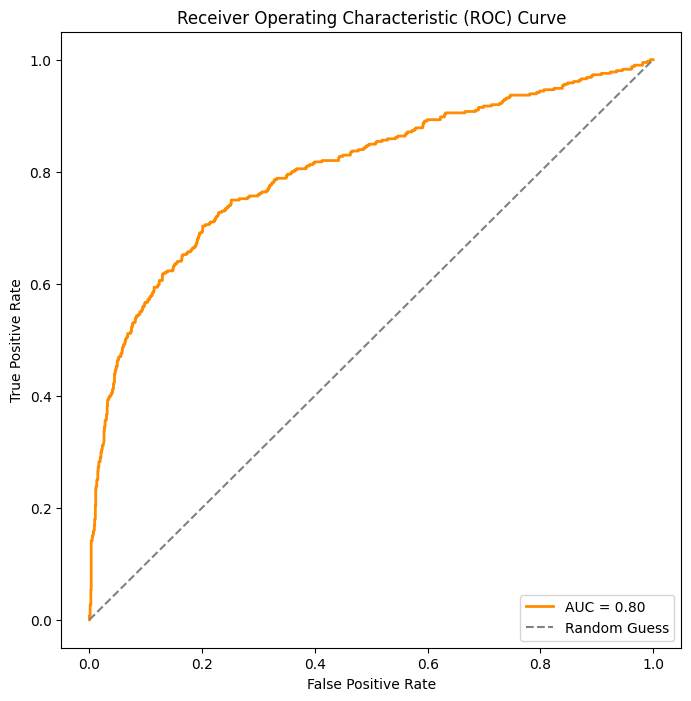

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
}

svc = SVC(probability=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validated Accuracy:", grid_search.best_score_)

best_svc = grid_search.best_estimator_
best_svc.fit(X_train, y_train)

train_predictions = best_svc.predict(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
print("\nTraining Accuracy:", train_accuracy)
test_predictions = best_svc.predict(X_test)

print("\nClassification Report on Test Data:")
print(classification_report(y_test, test_predictions))

conf_matrix = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Rain', 'Rain'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()
print("\n\n")

y_prob = best_svc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The model shows the best performance over the models, with accuracy = 0.85, and the training accuracy is 0.87, and they are close so we are not dealng with overfitting, and the values are high so no underfitting.

The best parameters for the SVC model is when {'C': 1}.

The AUC for the ROC curve = 0.80.

And the number of true predicted values = 1711.